In [1]:
import numpy as np
import sys
sys.path.append("../../src")
import hipopy
from ECALDataReader import ECALDataReader
import particle
import ROOT
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hipobase = "clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis."
#hiponums = ["0000","0001","0002","0003","0004","0005","0006","0007","0008","0009","0010"]
hiponums = ["0000","0001","0002","0003","0004"]
hipoproj = "../../projects/supercell.10.08.2024.18.28/"

def get_hipos(version=None):
    assert(version in ["old","new"])
    hipofiles = []
    for hiponum in hiponums:
        if version=="old":
            hipofiles.append(f"{hipoproj}/cooked/{hipobase}{hiponum}.hipo")
        else:
            hipofiles.append(f"{hipoproj}/predict/{hipobase}{hiponum}_ML.hipo")
    return hipofiles

oldhipos = get_hipos("old")
newhipos = get_hipos("new")

def get_particle_mass(pid):
    try:
        # Create a Particle instance from the given PID
        particle = Particle.from_pdgid(pid)
        # Return the mass of the particle
        return particle.mass
    except Exception:
        # Return 0 mass if the PID is not recognized
        return 0.0

def get_particle_properties(particle_df):
    # Initialize dictionary for particle properties
    properties = {"electron": [],
                  "proton":   [],
                  "neutron":  [],
                  "piplus":   [],
                  "piminus":  [],
                  "photon":   []}
    
    for index, particle in particle_df.iterrows():
        px = particle.px
        py = particle.py
        pz = particle.pz
        try:
            beta = particle.beta
        except:
            beta = -1
        p = np.sqrt(px**2 + py**2 + pz**2)
        pid = particle.pid
        m = get_particle_mass(pid)
        E = np.sqrt(p**2 + m**2)  # Energy from p and m
        theta = np.arctan2(np.sqrt(px**2 + py**2), pz)  # Polar angle
        phi = np.arctan2(py, px)  # Azimuthal angle
        # if theta<5*np.pi/180 or theta>35*np.pi/180:
        #     continue
        # Store particle properties in the appropriate list
        particle_data = {"p": p, "theta": theta, "phi": phi, "E": E, "beta": beta}
        
        if pid == 11:  # Electron
            properties["electron"].append(particle_data)
        elif pid == 2212:  # Proton
            properties["proton"].append(particle_data)
        elif pid == 2112:  # Neutron
            properties["neutron"].append(particle_data)
        elif pid == 211:  # Pi+
            properties["piplus"].append(particle_data)
        elif pid == -211:  # Pi-
            properties["piminus"].append(particle_data)
        elif pid == 22:  # Photon
            properties["photon"].append(particle_data)
    
    return properties

def get_particles(hipofile=""):
    reader = ECALDataReader(hipofile)
    
    # Initialize total vectors dictionaries
    total_rec_properties = {"electron": [],
                            "proton":   [],
                            "neutron":  [],
                            "piplus":   [],
                            "piminus":  [],
                            "photon":   []}
    
    total_mc_properties = {"electron": [],
                           "proton":   [],
                           "neutron":  [],
                           "piplus":   [],
                           "piminus":  [],
                           "photon":   []}
    
    for iev, event in tqdm(enumerate(reader.file)):
        rec_parts = reader.get_dict("REC::Particle")
        mc_parts  = reader.get_dict("MC::Particle")

        rec_properties = get_particle_properties(rec_parts)
        mc_properties  = get_particle_properties(mc_parts)

        # Accumulate REC properties
        for key in total_rec_properties:
            total_rec_properties[key].extend(rec_properties[key])
        
        # Accumulate MC properties
        for key in total_mc_properties:
            total_mc_properties[key].extend(mc_properties[key])

    return total_rec_properties, total_mc_properties

def ana(hipofiles):
    # Initialize grand total dictionaries for rec and mc properties
    grand_total_rec_properties = {"electron": [],
                                  "proton":   [],
                                  "neutron":  [],
                                  "piplus":   [],
                                  "piminus":  [],
                                  "photon":   []}
    
    grand_total_mc_properties = {"electron": [],
                                 "proton":   [],
                                 "neutron":  [],
                                 "piplus":   [],
                                 "piminus":  [],
                                 "photon":   []}
    
    # Loop over all HIPO files
    for hipofile in hipofiles:
        # Get the total properties for the current file
        total_rec_properties, total_mc_properties = get_particles(hipofile)
        
        # Accumulate REC properties
        for key in grand_total_rec_properties:
            grand_total_rec_properties[key].extend(total_rec_properties[key])
        
        # Accumulate MC properties
        for key in grand_total_mc_properties:
            grand_total_mc_properties[key].extend(total_mc_properties[key])
    
    # Return the grand totals
    return grand_total_rec_properties, grand_total_mc_properties


In [3]:
old_rec_vecs, old_mc_vecs = ana(oldhipos)

200it [00:02, 89.44it/s]
200it [00:02, 86.13it/s]
200it [00:02, 88.05it/s]
200it [00:02, 84.60it/s]
200it [00:02, 85.62it/s]

compression type = 0 data length = 337672
compression type = 0 data length = 337672
compression type = 0 data length = 337672
compression type = 0 data length = 337672
compression type = 0 data length = 337672


In [14]:
new_rec_vecs, new_mc_vecs = ana(newhipos)

500it [00:01, 424.47it/s]
500it [00:01, 447.61it/s]
500it [00:01, 406.20it/s]
500it [00:01, 433.52it/s]
500it [00:01, 404.87it/s]


compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839


In [5]:
def plot_particle_moments(particle_type, rec_properties, mc_properties, quantities=["p", "theta", "phi"], bins=50):
    # Prepare data for plotting
    rec_p = np.array([particle["p"] for particle in rec_properties[particle_type]])
    rec_theta = np.array([particle["theta"] for particle in rec_properties[particle_type]])
    rec_phi = np.array([particle["phi"] for particle in rec_properties[particle_type]])
    rec_beta = np.array([particle["beta"] for particle in rec_properties[particle_type]])

    mc_p = np.array([particle["p"] for particle in mc_properties[particle_type]])
    mc_theta = np.array([particle["theta"] for particle in mc_properties[particle_type]])
    mc_phi = np.array([particle["phi"] for particle in mc_properties[particle_type]])
    mc_beta = np.array([particle["beta"] for particle in mc_properties[particle_type]])

    # Determine common ranges for each quantity
    p_min, p_max = 0.001, 10
    theta_min, theta_max = 0.0001, 35/180*np.pi
    phi_min, phi_max = -np.pi, np.pi
    beta_min, beta_max = -1, 1

    # Initialize figure and dynamically adjust number of subplots based on quantities
    n_plots = len(quantities)
    fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    if n_plots == 1:
        axs = [axs]  # Ensure axs is always a list even with 1 subplot

    # Index to avoid complications (apply only to p, theta, and beta)
    idx_rec = (rec_p > p_min) & (rec_p < p_max) & (rec_theta > theta_min) & (rec_theta < theta_max)
    idx_mc = (mc_p > p_min) & (mc_p < p_max) & (mc_theta > theta_min) & (mc_theta < theta_max)

    rec_p, rec_theta, rec_phi, rec_beta = rec_p[idx_rec], rec_theta[idx_rec], rec_phi[idx_rec], rec_beta[idx_rec]
    mc_p, mc_theta, mc_phi, mc_beta = mc_p[idx_mc], mc_theta[idx_mc], mc_phi[idx_mc], mc_beta[idx_mc]

    # Plot based on the specified quantities
    for i, quantity in enumerate(quantities):
        if quantity == "p":
            axs[i].hist(rec_p, bins=np.linspace(p_min, p_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_p, bins=np.linspace(p_min, p_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Momentum (p)')
            axs[i].set_xlabel('Momentum (GeV)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "theta":
            axs[i].hist(rec_theta, bins=np.linspace(theta_min, theta_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_theta, bins=np.linspace(theta_min, theta_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Polar Angle (θ)')
            axs[i].set_xlabel('Theta (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "phi":
            axs[i].hist(rec_phi, bins=np.linspace(phi_min, phi_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_phi, bins=np.linspace(phi_min, phi_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Azimuthal Angle (φ)')
            axs[i].set_xlabel('Phi (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "beta":
            axs[i].hist(rec_beta, bins=np.linspace(beta_min, beta_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_beta, bins=np.linspace(beta_min, beta_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Beta (β)')
            axs[i].set_xlabel('Beta')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

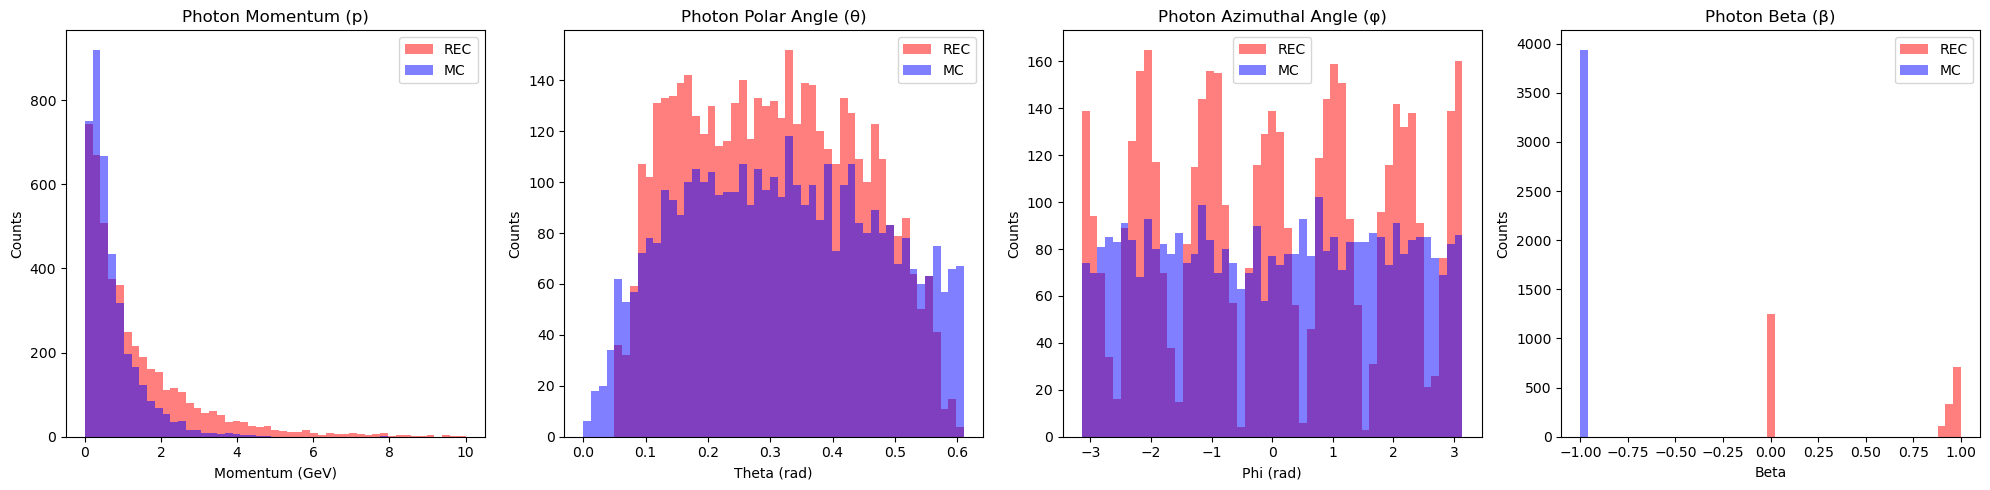

In [19]:
plot_particle_moments('photon',new_rec_vecs, new_mc_vecs, quantities=["p", "theta", "phi","beta"])

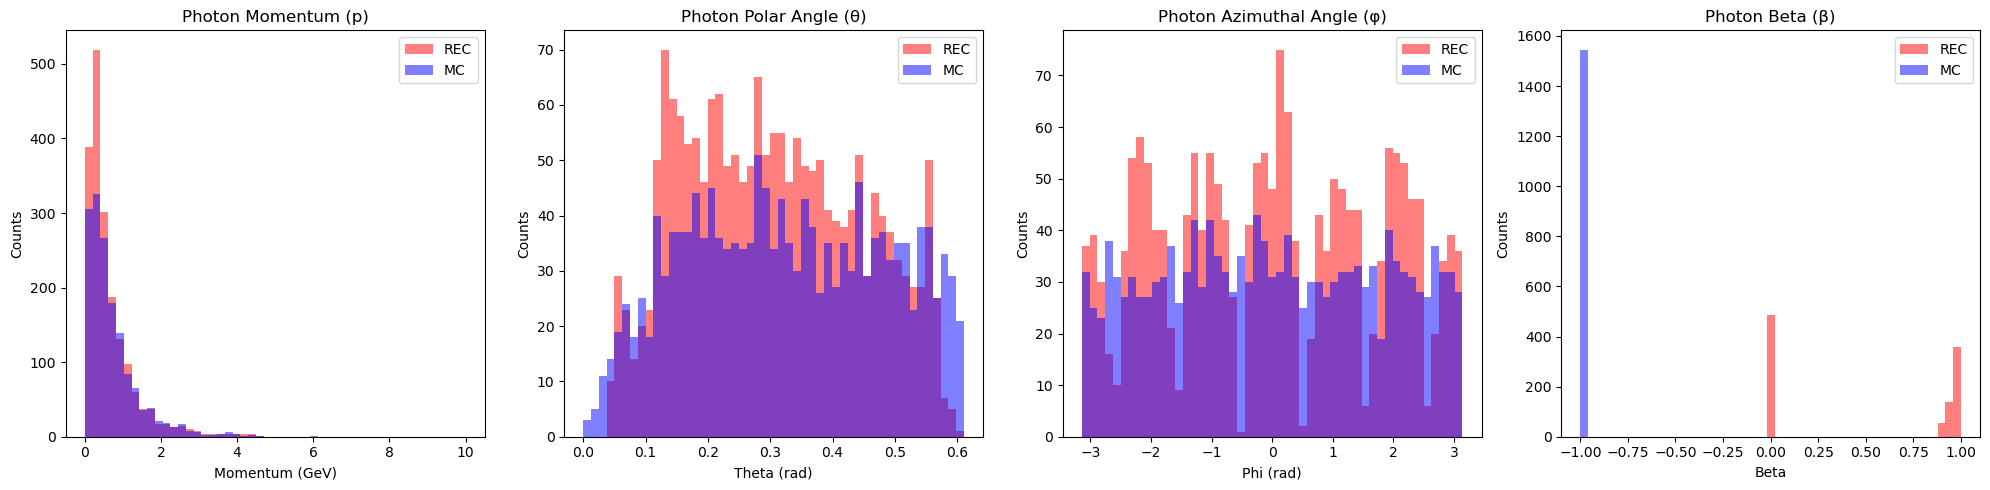

In [7]:
plot_particle_moments('photon',old_rec_vecs, old_mc_vecs, quantities=["p", "theta", "phi","beta"])

In [ ]:
ECALDataReader